In [1]:
################################ 
# Connect to google drive      #
################################
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
####################
# Libraries        #
####################

import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import plotly.graph_objects as go    # for data visualisation
import plotly.express as px
import matplotlib.pyplot as plt

import os
import glob

from sklearn.cluster import DBSCAN

In [3]:
###########################################
# Read the data from one file             #
###########################################
chunk = pd.read_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_0.0002.csv", chunksize=1000000)
df = pd.concat(chunk)

In [4]:
display(df.head())
# df.describe()
print("The columns of df: \n{}".format(df.columns))
print("\nThe dimentions of df:{}".format(df.shape))
# df.dtypes

,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Date,Above_1400K,Label
0,x0836342E_y684144N_l2140_s3091_v21,2017/01/01 01:03:38.689,68.414368,83.634171,1733.0,33.65390,67.0111,131.0860,0.0,3091,2017-01-01,True,0
1,x0836410E_y684024N_l2140_s3092_v21,2017/01/01 01:03:38.689,68.402435,83.640961,1884.0,14.46620,28.8822,40.4495,0.0,3092,2017-01-01,True,0
2,x0835980E_y684115N_l2141_s3091_v21,2017/01/01 01:03:38.689,68.411530,83.598038,1773.0,7.22975,14.3959,25.6943,0.0,3091,2017-01-01,True,0
3,x0836047E_y683998N_l2141_s3092_v21,2017/01/01 01:03:38.689,68.399780,83.604691,1517.0,5.98360,11.9463,39.7925,0.0,3092,2017-01-01,True,0
4,x0836079E_y684145N_l2149_s3091_v21,2017/01/01 01:03:40.468,68.414467,83.607948,1789.0,30.08700,59.8867,103.1950,0.0,3091,2017-01-01,True,0


The columns of df: 
Index(['id_Key', 'Date_Mscan', 'Lat_GMTCO', 'Lon_GMTCO', 'Temp_BB', 'RHI',
       'RH', 'Area_BB', 'Cloud_Mask', 'Sample_M10', 'Date', 'Above_1400K',
       'Label'],
      dtype='object')

The dimentions of df:(3332951, 13)


In [5]:
num_clusters = df["Label"].max() + 1
print(num_clusters)

clusters = pd.Series([df.loc[df["Label"]==n,["Lat_GMTCO","Lon_GMTCO"]].values for n in range(num_clusters)])
clusters

449943


0         [[68.41436800000001, 83.634171], [68.402435, 8...
1         [[67.788292, 83.52703100000002], [67.800095, 8...
2         [[67.85951999999999, 83.410522], [67.857208, 8...
3         [[69.61797299999999, 81.81869499999998], [69.6...
4         [[68.532013, 79.945961], [68.521263, 79.953987...
                                ...                        
449938                    [[30.061220000000002, 80.178497]]
449939                    [[29.923302000000003, 80.481323]]
449940                             [[29.899645, 80.431717]]
449941                    [[29.921353999999997, 79.000977]]
449942                             [[30.609135, 73.406723]]
Length: 449943, dtype: object

In [6]:
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
centermost_points

0                  (68.409103, 83.622475)
1          (67.79729499999999, 83.522552)
2                  (67.858391, 83.399261)
3          (69.620728, 81.82929200000002)
4          (68.516411, 79.94869200000002)
                       ...               
449938    (30.061220000000002, 80.178497)
449939    (29.923302000000003, 80.481323)
449940             (29.899645, 80.431717)
449941    (29.921353999999997, 79.000977)
449942             (30.609135, 73.406723)
Length: 449943, dtype: object

In [7]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'Lat_GMTCO_Label':lats, 'Lon_GMTCO_Label':lons})
rep_points["Label"] = np.arange(0, num_clusters,1).tolist()
rep_points

,Lat_GMTCO_Label,Lon_GMTCO_Label,Label
0,68.409103,83.622475,0
1,67.797295,83.522552,1
2,67.858391,83.399261,2
3,69.620728,81.829292,3
4,68.516411,79.948692,4
...,...,...,...
449938,30.061220,80.178497,449938
449939,29.923302,80.481323,449939
449940,29.899645,80.431717,449940
449941,29.921354,79.000977,449941


In [ ]:
# rs = rep_points.apply(lambda row: df[(df['Lat_GMTCO']==row['Lat_GMTCO_Label']) & (df['Lon_GMTCO']==row['Lon_GMTCO_Label'])].iloc[0], axis=1)
# rs

# Add extra column for temperature, latitude, longitude according to the cluster label

In [ ]:
#df_test["Temp_BB"].groupby([df_test["Label"], df_test["Date"]]).transform("max")

0          2271.0
1          2271.0
2          2271.0
3          2271.0
4          2271.0
            ...  
3332946    2470.0
3332947    2253.0
3332948    2116.0
3332949    2116.0
3332950    2197.0
Name: Temp_BB, Length: 3332951, dtype: float64

In [79]:
df_test = df.copy()
df_test["Temp_BB_Max_Label"] = df_test["Temp_BB"].groupby(df_test["Label"]).transform("max")
df_test["Temp_BB_Min_Label"] = df_test["Temp_BB"].groupby(df_test["Label"]).transform("min")
df_test["Temp_BB_Mean_Label"] = df_test["Temp_BB"].groupby(df_test["Label"]).transform("mean")
df_test["Temp_BB_Std_Label"] = df_test["Temp_BB"].groupby(df_test["Label"]).transform("std")
df_test["Temp_BB_Label_Day"] = df_test["Temp_BB"].groupby([df_test["Label"], df_test["Date"]]).transform("max")

df_test["Area_BB_Max_Label"] = df_test["Area_BB"].groupby(df_test["Label"]).transform("max")
df_test["Area_BB_Min_Label"] = df_test["Area_BB"].groupby(df_test["Label"]).transform("min")
df_test["Area_BB_Mean_Label"] = df_test["Area_BB"].groupby(df_test["Label"]).transform("mean")
df_test["Area_BB_StdLabel"] = df_test["Area_BB"].groupby(df_test["Label"]).transform("std")
df_test["Area_BB_Label_Day"] = df_test["Area_BB"].groupby([df_test["Label"], df_test["Date"]]).transform("max")

df_test["RHI_Max_Label"] = df_test["RHI"].groupby(df_test["Label"]).transform("max")
df_test["RHI_Min_Label"] = df_test["RHI"].groupby(df_test["Label"]).transform("min")
df_test["RHI_Mean_Label"] = df_test["RHI"].groupby(df_test["Label"]).transform("mean")
df_test["RHI_StdLabel"] = df_test["RHI"].groupby(df_test["Label"]).transform("std")
df_test["RHI_Label_Day"] = df_test["RHI"].groupby([df_test["Label"], df_test["Date"]]).transform("max")

In [80]:
df_test[df_test["Label"]==10]

,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Date,Above_1400K,Label,Temp_BB_Max_Label,Temp_BB_Min_Label,Temp_BB_Mean_Label,Temp_BB_Std_Label,Temp_BB_Label_Day,Area_BB_Max_Label,Area_BB_Min_Label,Area_BB_Mean_Label,Area_BB_StdLabel,Area_BB_Label_Day,RHI_Max_Label,RHI_Min_Label,RHI_Mean_Label,RHI_StdLabel,RHI_Label_Day
29,x0725274E_y678154N_l2766_s3035_v21,2017/01/01 01:04:48.081,67.815376,72.527374,1766.0,22.406500,38.684500,70.146900,0.0,3035,2017-01-01,True,10,2500.0,636.0,2001.626132,197.179766,2462.0,6824.25,0.067479,14.515748,104.488927,385.755,604.872,0.255522,6.882048,25.529718,264.3860
30,x0725384E_y678053N_l2766_s3036_v21,2017/01/01 01:04:48.081,67.805344,72.538422,1779.0,44.458300,76.943500,135.539000,0.0,3036,2017-01-01,True,10,2500.0,636.0,2001.626132,197.179766,2462.0,6824.25,0.067479,14.515748,104.488927,385.755,604.872,0.255522,6.882048,25.529718,264.3860
31,x0725495E_y677953N_l2766_s3037_v21,2017/01/01 01:04:48.081,67.795265,72.549507,2246.0,1.010000,1.752240,1.214780,0.0,3037,2017-01-01,True,10,2500.0,636.0,2001.626132,197.179766,2462.0,6824.25,0.067479,14.515748,104.488927,385.755,604.872,0.255522,6.882048,25.529718,264.3860
32,x0725214E_y678176N_l2774_s3035_v21,2017/01/01 01:04:49.860,67.817581,72.521446,1724.0,7.655820,13.211700,26.382500,3.0,3035,2017-01-01,True,10,2500.0,636.0,2001.626132,197.179766,2462.0,6824.25,0.067479,14.515748,104.488927,385.755,604.872,0.255522,6.882048,25.529718,264.3860
33,x0725326E_y678076N_l2774_s3036_v21,2017/01/01 01:04:49.860,67.807632,72.532623,1739.0,94.708000,163.834000,315.783000,3.0,3036,2017-01-01,True,10,2500.0,636.0,2001.626132,197.179766,2462.0,6824.25,0.067479,14.515748,104.488927,385.755,604.872,0.255522,6.882048,25.529718,264.3860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325710,x0724357E_y677573N_l0424_s0890_v30,2017/12/31 21:00:24.026,67.757271,72.435669,2387.0,0.335946,0.283374,0.153857,3.0,890,2017-12-31,True,10,2500.0,636.0,2001.626132,197.179766,2387.0,6824.25,0.067479,14.515748,104.488927,105.881,604.872,0.255522,6.882048,25.529718,65.7701
3328109,x0724659E_y678466N_l0025_s2928_v30,2017/12/31 00:39:10.140,67.846588,72.465851,1929.0,1.200130,1.628730,2.075730,3.0,2928,2017-12-31,True,10,2500.0,636.0,2001.626132,197.179766,2387.0,6824.25,0.067479,14.515748,104.488927,105.881,604.872,0.255522,6.882048,25.529718,65.7701
3328110,x0724777E_y678386N_l0025_s2929_v30,2017/12/31 00:39:10.140,67.838570,72.477654,2049.0,0.935252,1.271910,1.272490,3.0,2929,2017-12-31,True,10,2500.0,636.0,2001.626132,197.179766,2387.0,6824.25,0.067479,14.515748,104.488927,105.881,604.872,0.255522,6.882048,25.529718,65.7701
3328111,x0725602E_y677824N_l0025_s2936_v30,2017/12/31 00:39:10.140,67.782356,72.560173,1857.0,3.080890,4.251460,6.301830,3.0,2936,2017-12-31,True,10,2500.0,636.0,2001.626132,197.179766,2387.0,6824.25,0.067479,14.515748,104.488927,105.881,604.872,0.255522,6.882048,25.529718,65.7701


In [82]:
# df_test["Lat_GMTCO_Label"] = df_test.merge(rep_points, on="Label")['Lat_GMTCO_Label']#df_test.apply(lambda row: rep_points.iloc[row.Label][1], axis=1)
# df_test["Lon_GMTCO_Label"] = df_test.merge(rep_points, on="Label")['Lon_GMTCO_Label']#df_test.apply(lambda row: rep_points.iloc[row.Label][0], axis=1) #

df_merge = df_test.merge(rep_points, on="Label")
df_merge
df_merge[df_merge["Label"]==9]

#df_merge.to_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_DBSCANFinalWith0.0002.csv")

In [ ]:
#df_merge.to_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_DBSCANFinalWith0.01.csv")

In [11]:
df_merge.head()
df_merge.shape

(3332951, 17)

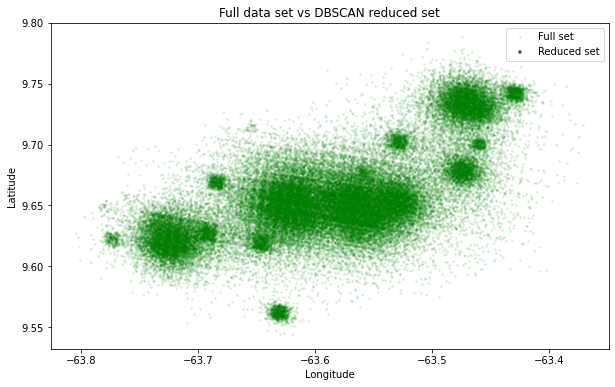

In [78]:
df_selected = df_merge.copy()
#df_selected = df_selected[df_selected["Label"]==2700]

fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(df_selected['Lon_GMTCO_Label'], df_selected['Lat_GMTCO_Label'], c='black', edgecolor='None', alpha=0.7, s=12)
df_scatter = ax.scatter(df_selected['Lon_GMTCO'], df_selected['Lat_GMTCO'], c='green', alpha=0.1, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

#Plot the histogram of one cluster across the time

(3, 17)


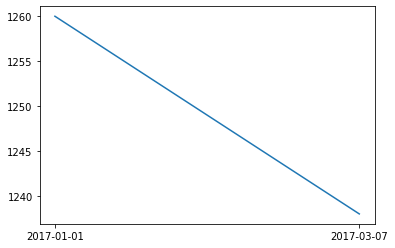

In [13]:
test_ = df_merge[df_merge['Label']==100].sort_values(by="Date")
print(test_.shape)

plt.plot(test_["Date"],test_["Temp_BB_Label_Day"])
plt.show()

#Plot the center_most points from each cluster on the map according to whether temperature above 1400K or below 1400K

In [14]:
df_selected = rep_points.copy()

df_selected['text'] ="" #'RH:=' + df_selected['RH'].astype(str) + ' <br>RHI:=' + df_selected['RHI'].astype(str) + ' <br>Temp_BB: '+ df_selected['Temp_BB'].astype(str)+ ' <br>Area_BB: '+ df_selected['Area_BB'].astype(str)
fig = go.Figure(data = go.Scattergeo(
    lon = df_selected["Lon_GMTCO_Label"],
    lat = df_selected["Lat_GMTCO_Label"],
    text = df_selected["text"],
    mode = "markers",
    marker = dict(
        size = 10,
        opacity = 0.8,
        reversescale = True, # set the reversescale and autocolorscale as True to enable the color of markers automatically changed
        autocolorscale = True,
        symbol = 'x',
        line = dict(
            width = 1,
            color = 'rgba(102, 102, 102)'
        ),
        cmin = 0, # cmin/cmax == lower/upper bound of the color domain for the data points
        color = df_selected['Temp_BB_Label_Day'],
        cmax = df_selected['Temp_BB_Label_Day'].max(), #
        colorbar_title = "Temperature"
    )
))

fig.update_layout(
    title = "BRAINWAVE - GAS FLARING",
    geo = dict(
        scope = "world", # ccope options: world, usa, europe, africa, north america, south america
        showland = True,
    )
)

fig.show()
#fig.write_html('first_figure.html', auto_open=True) #generate a HTML page that shows the scatter map

KeyError: ignored

In [77]:
sizeEachCluster=df_merge_smaller.groupby(["Label"])["Lat_GMTCO"].count()
sizeEachCluster.describe()
#sizeEachCluster[sizeEachCluster>=350]

count    449943.000000
mean          2.610282
std          13.460380
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         350.000000
Name: Lat_GMTCO, dtype: float64

In [76]:
sizeEachCLuster=df_merge.groupby(["Label"])["Lat_GMTCO"].count()
sizeEachCLuster.describe()
#sizeEachCluster[sizeEachCluster>=58257]

count    449943.000000
mean          7.407496
std         131.577370
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max       58257.000000
Name: Lat_GMTCO, dtype: float64

(array([1120821.,  181673.,   71205.,   72778.,   52155.,   39938.,
          33789.,   29134.,   23627.,   28279.,   22283.,   18384.,
          19343.,   17528.,   18348.,   15795.,   16850.,   25761.,
          16609.,   18060.,   16296.,   19474.,   24016.,   16321.,
          15797.,   18737.,   15797.,   19377.,   18597.,   17130.,
          17599.,   17276.,   14383.,   19847.,   17329.,   18848.,
          20968.,   18766.,   22631.,   21611.,   24414.,   24926.,
          21480.,   21868.,   30434.,   38841.,   34375.,   30237.,
          28812.,   35970.,   29290.,   34892.,   42832.,   28029.,
          28318.,   23706.,   21513.,   21629.,   19733.,   19816.,
          22491.,   23567.,   21101.,   18087.,   17669.,   17268.,
          16697.,   16930.,   18334.,   17081.,   17578.,   14945.,
          17522.,   15169.,   15805.,   15258.,   15618.,   15691.,
          15772.,   15542.,   18367.,   16488.,   17629.,   17010.,
          13274.,   14291.,   12942.,   16169., 

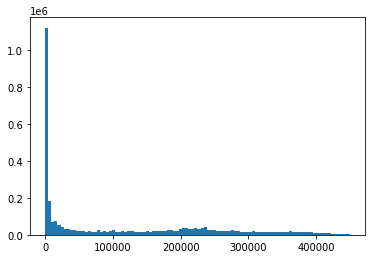

In [45]:
plt.hist(df_selected['Label'], bins=100)

(array([4062.,  903.,  408., ..., 1229., 2021.,  883.]),
 array([0.00000000e+00, 9.99285714e-01, 1.99857143e+00, ...,
        1.39700143e+03, 1.39800071e+03, 1.39900000e+03]),
 <a list of 1400 Patch objects>)

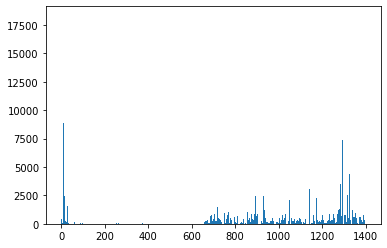

In [64]:
plt.hist(df_selected[df_selected['Label']<1400]['Label'], bins=1400)

In [83]:
df_merge_smaller = df_merge.drop_duplicates(["Date","Label"]) #df_merge.groupby(["Date","Label"]).first()
df_merge_smaller

df_merge_smaller.to_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_DBSCANFinalWith0.0002_COMPRESSED.csv")

In [58]:
df_merge_smaller.shape

(1174478, 17)

In [84]:
rs = rep_points.apply(lambda row: df_merge[(df_merge['Lat_GMTCO']==row['Lat_GMTCO_Label']) & (df_merge['Lon_GMTCO']==row['Lon_GMTCO_Label'])].iloc[0], axis=1)
rs

,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Date,Above_1400K,Label,Temp_BB_Max_Label,Temp_BB_Min_Label,Temp_BB_Mean_Label,Temp_BB_Std_Label,Temp_BB_Label_Day,Area_BB_Max_Label,Area_BB_Min_Label,Area_BB_Mean_Label,Area_BB_StdLabel,Area_BB_Label_Day,RHI_Max_Label,RHI_Min_Label,RHI_Mean_Label,RHI_StdLabel,RHI_Label_Day,Lat_GMTCO_Label,Lon_GMTCO_Label
0,x0836225E_y684091N_l0597_s2762_v21,2017/11/10 23:37:00.763,68.409103,83.622475,1783.0,40.469900,40.249200,70.286400,1.0,2762,2017-11-10,True,0,2500.0,1065.0,1941.363614,193.987657,2146.0,377.34600,0.077106,12.933069,26.842369,70.28640,111.151000,0.257765,6.203263,11.458823,46.875200,68.409103,83.622475
1,x0835226E_y677973N_l1694_s2077_v21,2017/02/16 22:03:17.110,67.797295,83.522552,2172.0,0.415647,0.346884,0.274937,3.0,2077,2017-02-16,True,1,2483.0,568.0,1777.607973,346.383254,2260.0,225.29000,0.085037,6.616613,14.273149,68.47960,55.399500,0.259088,1.807915,3.341784,55.399500,67.797295,83.522552
2,x0833993E_y678584N_l0804_s0125_v21,2017/01/03 19:07:07.003,67.858391,83.399261,1981.0,1.767480,3.390210,3.884210,0.0,125,2017-01-03,True,2,2333.0,902.0,1883.656863,163.008659,2201.0,59.27090,0.161440,4.013785,4.876577,9.20320,25.974000,0.268409,2.061008,2.083913,3.127370,67.858391,83.399261
3,x0818293E_y696207N_l0281_s1953_v21,2017/11/20 22:09:36.446,69.620728,81.829292,1931.0,2.766030,1.940870,2.460260,1.0,1953,2017-11-20,True,3,2383.0,1101.0,1748.646536,162.526333,1931.0,58.59480,0.188412,5.304818,5.417266,7.16263,14.961900,0.261412,2.244051,1.584091,3.790560,69.620728,81.829292
4,x0799487E_y685164N_l0917_s0513_v21,2017/02/28 19:57:12.991,68.516411,79.948692,1730.0,3.882040,3.433330,6.756840,0.0,513,2017-02-28,True,4,2498.0,638.0,1935.358164,207.263138,2234.0,297.72100,0.069499,6.489901,13.713032,16.31860,78.626900,0.246062,3.583848,5.918761,13.004500,68.516411,79.948692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449938,x0801785E_y300612N_l0377_s2814_v30,2017/12/31 21:10:16.523,30.061220,80.178497,1291.0,2.433290,2.625390,16.670200,1.0,2814,2017-12-31,False,449938,1291.0,1291.0,1291.000000,NaN,1291.0,16.67020,16.670200,16.670200,NaN,16.67020,2.433290,2.433290,2.433290,NaN,2.433290,30.061220,80.178497
449939,x0804813E_y299233N_l0389_s2851_v30,2017/12/31 21:10:18.302,29.923302,80.481323,1205.0,0.765487,0.883840,7.398760,1.0,2851,2017-12-31,False,449939,1205.0,1205.0,1205.000000,NaN,1205.0,7.39876,7.398760,7.398760,NaN,7.39876,0.765487,0.765487,0.765487,NaN,0.765487,29.923302,80.481323
449940,x0804317E_y298996N_l0392_s2846_v30,2017/12/31 21:10:18.302,29.899645,80.431717,1316.0,1.109510,1.269670,7.461210,1.0,2846,2017-12-31,False,449940,1316.0,1316.0,1316.000000,NaN,1316.0,7.46121,7.461210,7.461210,NaN,7.46121,1.109510,1.109510,1.109510,NaN,1.109510,29.899645,80.431717
449941,x0790010E_y299214N_l0440_s2681_v30,2017/12/31 21:10:23.640,29.921354,79.000977,1152.0,0.642558,0.557358,5.578000,1.0,2681,2017-12-31,False,449941,1152.0,1152.0,1152.000000,NaN,1152.0,5.57800,5.578000,5.578000,NaN,5.57800,0.642558,0.642558,0.642558,NaN,0.642558,29.921354,79.000977


In [85]:
#rs.to_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_DBSCANFinalWith0.0002_onlyCenterMostPoint.csv")